In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Activation, Conv2D, Conv2DTranspose, Concatenate, BatchNormalization

import keras

import os
from glob import glob
from typing import List
import enum

from utils import multipredict
from utils.loading import data_generator, map_weights

import matplotlib.pyplot as plt
import numpy as np

2024-04-11 11:45:41.310090: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-11 11:45:42.565509: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
tf.config.list_physical_devices()

2024-04-11 11:45:48.995741: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 11:45:49.012301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 11:45:49.012947: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Dataset

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH  = 224
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS)

NUM_CLASSES = 5
BATCH_SIZE = 4

In [ ]:
DATA_DIR = "dataset"

train_dataset = data_generator(
    sorted(glob('dataset/augmented_images_train/*.jpg')),
    sorted(glob('dataset/augmented_masks_train/*.png')),
    BATCH_SIZE,
    NUM_CLASSES,
    IMG_SHAPE
)
val_dataset = data_generator(
    sorted(glob('dataset/augmented_images_val/*.jpg')),
    sorted(glob('dataset/augmented_masks_val/*.png')),
    BATCH_SIZE,
    NUM_CLASSES,
    IMG_SHAPE
)

# Ading class weights
class_weights = tf.constant([1,1,5,1,0.8])
train_dataset = train_dataset.map(lambda image, label: map_weights(image, label, class_weights)) # Map the function to the dataset

print("Train Dataset:  ", train_dataset)
print("Val Dataset:  ", val_dataset)

# Model (VGG16 feautre extractor + decoder)

A pretrained model is provided under `models/VGG16unet-224x224-50epochs.model.keras`. If you don't have this model it is publicly available in [kaggle](https://www.kaggle.com/models/sergiogarciapajares/vggcloudunet/).

## Load pretrained model

In [4]:
model = tf.keras.models.load_model('models/VGG16unet-224x224-50epochs.model.keras')

2024-04-11 11:45:58.500621: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 11:45:58.501097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-11 11:45:58.501451: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

## Define the model from scratch

In [ ]:
def conv_block(inputs,num_filters):
  x = Conv2D(num_filters,3,padding='same')(inputs)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(num_filters,3,padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x) 
  
  return x

def define_decoder(inputs,skip_layer,num_filters):
  x = Conv2DTranspose(num_filters,(2,2),strides=(2,2),padding='same',kernel_initializer='he_normal')(inputs) 
  g = Concatenate()([x,skip_layer])
  g = conv_block(g,num_filters)
  return g

def vgg16_unet(input_shape,num_classes):
  inputs = Input(shape=input_shape)
  vgg16 = VGG16(include_top=False,weights='imagenet',input_tensor=inputs)  # We will extract encoder layers based on their output shape from vgg16 model

  for layer in vgg16.layers:
    layer.trainable = False

  s1 = vgg16.get_layer('block1_conv2').output  
  s2 = vgg16.get_layer('block2_conv2').output  
  s3 = vgg16.get_layer('block3_conv3').output  
  s4 = vgg16.get_layer('block4_conv3').output    # bottleneck/bridege layer from vgg16
  b1 = vgg16.get_layer('block5_conv3').output #32
  
  # Decoder Block
  d1 = define_decoder(b1,s4,512)
  d2 = define_decoder(d1,s3,256)
  d3 = define_decoder(d2,s2,128)
  d4 = define_decoder(d3,s1,64)  #output layer
  outputs = Conv2D(num_classes,1,padding='same',activation='softmax')(d4)
  model = Model(inputs,outputs)
  
  return model


In [ ]:
model = vgg16_unet((IMG_WIDTH,IMG_HEIGHT,IMG_CHANNELS), NUM_CLASSES)

Alternatively, we can load the weights of the pretrained model or train it from scratch in the above section.

In [ ]:
model.load_weights('models/VGG16unet-224x224-50epochs.model.keras')

## View model

In [ ]:
model.summary()

# Train

The model encoder `VGG16` is setup to be non-trainable. Pre-trained weights on the [ImageNet dataset](https://www.image-net.org/) are used. Thus, only the decoder is trained, greatly reducing training computational cost. 

In [ ]:
model.compile(
    optimizer=Adam(
        learning_rate = 1e-3,
        beta_1 = .9,
        beta_2 = .999
    ),
    loss='categorical_crossentropy',
    metrics=[
        tf.keras.metrics.OneHotIoU(
            
            num_classes=NUM_CLASSES,
            target_class_ids=[i for i in range(NUM_CLASSES)],
            sparse_y_pred = False # when false retrive prediction with tf.argmax
        ),
    ]
)


In [ ]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        patience=6,
        monitor='val_loss'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=3,
        verbose=1,
        mode='auto',
        min_delta=0.0001,
    ),
    tf.keras.callbacks.TensorBoard(
        log_dir='logs'
    ),
    tf.keras.callbacks.History(
    ),
    tf.keras.callbacks.ModelCheckpoint(
        os.path.join('models','checkpoints','Checkpoint.model.keras'),
        monitor='val_loss',
        verbose=2,
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        save_freq='epoch',
        initial_value_threshold=None
    ),
    # tf.keras.callbacks.BackupAndRestore(
    #     os.path.join('models','checkpoints','BackupCheckpoint.model.keras'),
    #     save_freq='epoch',
    #     delete_checkpoint=True
    # )
]

In [ ]:
history = model.fit(
    x=train_dataset,
    epochs=100,
    verbose=2,
    callbacks=callbacks,
    validation_data=val_dataset,
    shuffle=True,
    initial_epoch=50,
)
# Run 1:   237 m 33.2 s 39 epochs, 39 epochs
# Run 1.1:   6 m 67.4 s  1 epochs, 40 epochs
# Run 2:    53 m  1.3 s 10 epochs, 50 epochs
# Run 3


In [ ]:
model.save('models/VGG16unet-224x224-54epochs.model.keras')

In [ ]:
history.history.keys()

In [ ]:
plt.plot(history.history['val_loss'],'r-', label='Validation Loss')
plt.plot(history.history['loss'],'r--', label='Loss')
plt.plot(history.history['one_hot_io_u'],'b--',label='IoU')
plt.plot(history.history['val_one_hot_io_u'],'b-',label='Validation IOU')

plt.xlabel('Epochs')
plt.xlim(0)
plt.ylim(0)
plt.legend()

# Evaluate model performance

In [5]:
test_images = [os.path.join('dataset','images',name.strip()) for name in open('dataset/test.txt').readlines()]
test_masks = [os.path.join('dataset','masks',name.strip()) for name in open('dataset/test.txt').readlines()]

I0000 00:00:1712829426.033700   31267 service.cc:145] XLA service 0x7f7ea4014170 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1712829426.033739   31267 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce GTX 1050, Compute Capability 6.1
2024-04-11 11:57:06.065000: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-11 11:57:06.321012: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


I0000 00:00:1712829432.544496   31267 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

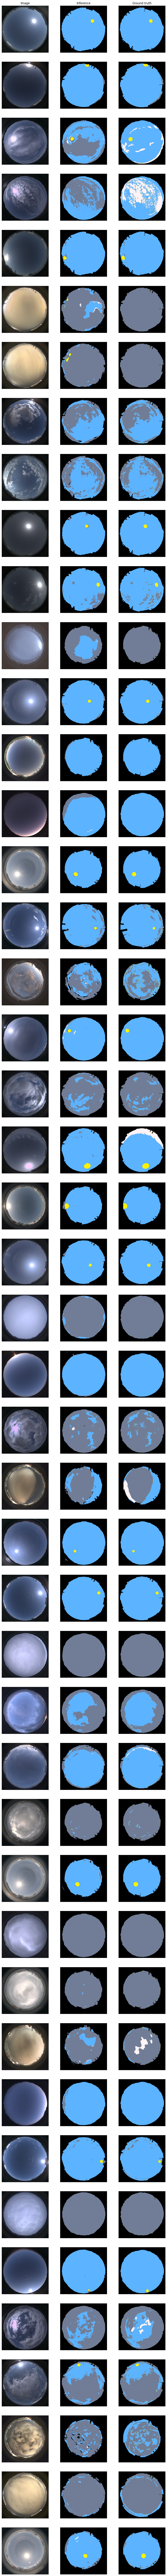

In [6]:
multipredict(test_images,test_masks,model)
plt.savefig("VGG16unet-224x224-50epochs.jpg")